In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from model import SimpleCNN
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

# 設定超參數
batch_size = 20
learning_rate = 0.001
num_epochs = 30

# 資料轉換
transform = transforms.Compose([
    transforms.Resize((240, 320)),
    transforms.ToTensor(),
])

# 指定訓練和測試資料集路徑
train_dir = 'dataset_scale/train'  # 指定訓練資料集資料夾路徑
test_dir = 'dataset_scale/test'    # 指定測試資料集資料夾路徑

# 加載資料集
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 設定設備
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 初始化模型、損失函數和優化器
model = SimpleCNN(num_classes=11).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# 訓練和測試過程中記錄損失和準確率
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

# 訓練函數
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    return running_loss / len(train_loader), accuracy

# 測試函數
def test(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    accuracy = 100 * correct / total
    return running_loss / len(test_loader), accuracy, all_labels, all_predictions

# 訓練過程
for epoch in range(num_epochs):
    train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, device)
    test_loss, test_accuracy, all_labels, all_predictions = test(model, test_loader, criterion, device)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

# 保存模型
torch.save(model.state_dict(), 'simple_cnn_1220_epoch30.pth')


Epoch [1/30], Train Loss: 0.8716, Train Accuracy: 70.35%, Test Loss: 1.0661, Test Accuracy: 69.70%
Epoch [2/30], Train Loss: 0.1210, Train Accuracy: 95.71%, Test Loss: 1.1087, Test Accuracy: 72.73%
Epoch [3/30], Train Loss: 0.0500, Train Accuracy: 98.32%, Test Loss: 1.0031, Test Accuracy: 80.61%
Epoch [4/30], Train Loss: 0.0366, Train Accuracy: 98.80%, Test Loss: 1.1287, Test Accuracy: 78.18%
Epoch [5/30], Train Loss: 0.0390, Train Accuracy: 98.84%, Test Loss: 1.0308, Test Accuracy: 78.18%
Epoch [6/30], Train Loss: 0.0186, Train Accuracy: 99.46%, Test Loss: 1.4948, Test Accuracy: 74.55%
Epoch [7/30], Train Loss: 0.0274, Train Accuracy: 99.03%, Test Loss: 1.3797, Test Accuracy: 77.58%
Epoch [8/30], Train Loss: 0.0150, Train Accuracy: 99.47%, Test Loss: 1.3246, Test Accuracy: 79.39%
Epoch [9/30], Train Loss: 0.0256, Train Accuracy: 99.26%, Test Loss: 1.5565, Test Accuracy: 73.94%
Epoch [10/30], Train Loss: 0.0152, Train Accuracy: 99.63%, Test Loss: 1.4326, Test Accuracy: 79.39%
Epoch [11

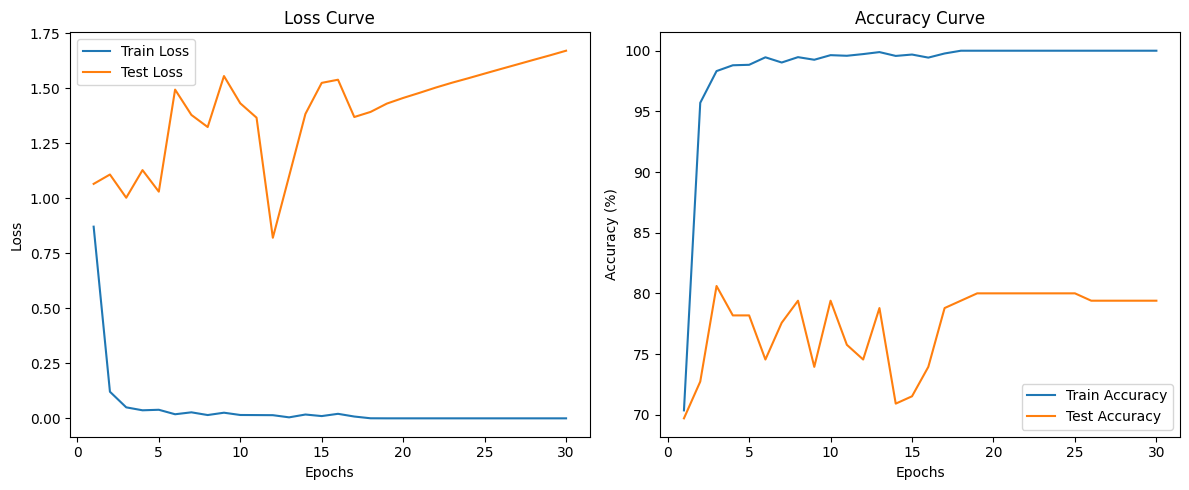

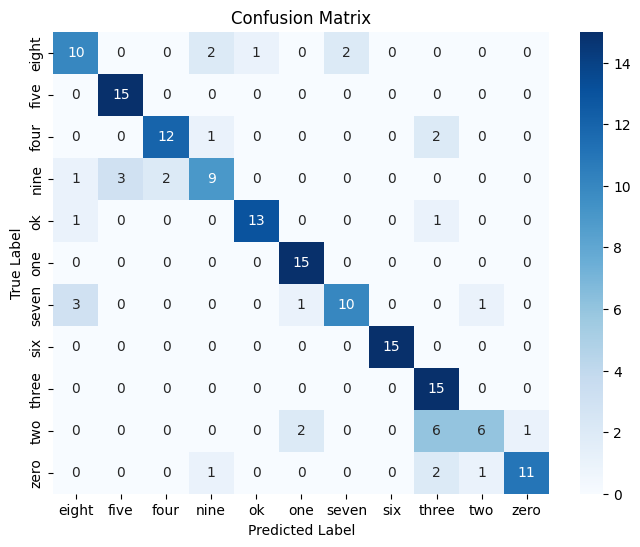

In [3]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# 繪製 accuracy curve 和 loss curve
plt.figure(figsize=(12, 5))

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

# Accuracy curve
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')  # 修正這裡
plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Curve')
plt.legend()

plt.tight_layout()
plt.show()

# 混淆矩陣
conf_matrix = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
